# RADI 6060 Homework 3
#### Gweneth Andersen
#### 4/18/2024

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# random number generator using the multiplicative congruential algorithm
class MultiplicativeCongruentialGenerator():
    def __init__(self, initialSeed: int, I1: int, M: int): 
        self.multiplier = I1
        self.modulus = M
        self.seed = initialSeed % self.modulus
        self.randomNumber = self.seed / self.modulus
        self.seeds = [self.seed]
        self.randomNumbers = [self.randomNumber]
    
    # generate and return the next random number in the multiplicative congruential sequence
    def generateNext(self):
        newSeed = (self.multiplier * self.seed) % self.modulus
        self.seed = newSeed
        self.seeds.append(self.seed)
        newRandomNumber = newSeed / self.modulus
        self.randomNumber = newRandomNumber
        self.randomNumbers.append(self.randomNumber)
        return newRandomNumber
    
    # generate N more random numbers and return them in a list
    def generateNextN(self, N: int):
        newRandomNumbers = []
        for i in range(N):
            newRandomNumber = self.generateNext()
            newRandomNumbers.append(newRandomNumber)
        return newRandomNumbers

class Medium():
    def __init__(self, xs: dict):
        self.xs = xs
        self.xs_a = self.xs["xs_a"]
        self.xs_s = self.xs["xs_s"]
        self.xs_total = {energy: self.xs_a[energy] + self.xs_s[energy] for energy in self.xs_a.keys()}
    
water_xs = {
    "xs_a": {
        50.0: 2.725 * 10**-2,
        100.0: 2.763 * 10**-2
    },
    "xs_s": {
        50.0: 1.803 * 10**-1,
        100.0: 1.626 * 10**-1
    }
}

water = Medium(water_xs)
    
class Particle():
    def __init__(self, x: float, y: float, z: float,
                 mu: float, phi: float, omegaX: float, omegaY: float, omegaZ: float,
                 E: float, rng: MultiplicativeCongruentialGenerator):
        self.x = x
        self.y = y
        self.z = z
        self.mu = mu
        self.phi = phi
        self.omegaX = omegaX
        self.omegaY = omegaY
        self.omegaZ = omegaZ
        self.E = E
        self.rng = rng
        
    # sample collisional pdf to determine where the next collision will occur, given a medium M
    def computeNextCollisionPosition(self, medium: Medium, i=None):
        R = self.rng.generateNext()
        if i is not None:
            print("Random number generated to compute collision position: {}".format(R))
        collision_distance = -np.log(R) / medium.xs_total[self.E]
        new_x = self.x + self.omegaX*collision_distance
        new_y = self.y + self.omegaY*collision_distance
        new_z = self.z + self.omegaZ*collision_distance
        self.x = new_x
        self.y = new_y
        self.z = new_z
        
    # sample non-absorption probability to determine whether an interaction will be absorption or scattering
    def isAbsorbed(self, medium: Medium, i=None):
        R = self.rng.generateNext()
        if i is not None:
            print("Random number generated to sample absorption: {}".format(R))
        return R <= medium.xs_a[self.E]/medium.xs_total[self.E]
    
    # use rejection sampling to compute a scatter cosine
    def computeScatterCosine(self, i=None):
        # pdf(mu) = 1 + mu^2
        # integral of pdf(mu) from -1 to 1 = 8/3 = normalization constant
        # normalized pdf(mu) = (3/8)*(1 + mu^2)
        new_mu = -1.0 + 2.0*self.rng.generateNext()
        if i is not None:
            print("Random number generated for new scatter cosine mu: {}".format(new_mu))
        pdf_mu = 0.375 * (1.0 + new_mu**2)
        R = 0.75 * self.rng.generateNext()
        if i is not None:
            print("Random number generated for rejection sampling: {}".format(R))
        if R < pdf_mu:
            return new_mu
        else:
            return self.computeScatterCosine(i)
        
    # sample angular distribution (polar angle and azimuthal angle) to determine new direction for particle in directional coordinate system
    def computeNextAngle(self, medium: Medium, i=None):
        new_mu = self.computeScatterCosine(i)
        # azimuthal angle uniformly distributed from 0 to 2pi
        R_azimuthal = self.rng.generateNext()
        new_phi = 2.0*np.pi*R_azimuthal # in directional coordinate system
        # compute directional cosines
        sin_theta = (1.0 - new_mu**2)**0.5
        k = (1.0 - self.omegaZ**2)**0.5
        new_omegaX = self.omegaX*new_mu \
                    + (self.omegaZ*self.omegaX*sin_theta*np.cos(new_phi) / k) \
                    + (self.omegaY*sin_theta*np.sin(new_phi) / k)
        new_omegaY = self.omegaY*new_mu \
                    + (self.omegaZ*self.omegaY*sin_theta*np.cos(new_phi) / k) \
                    + (self.omegaX*sin_theta*np.sin(new_phi) / k)
        new_omegaZ = self.omegaZ*new_mu - sin_theta*np.cos(new_phi) * k
        # convert to stationary coordinate system
        self.omegaX = new_omegaX
        self.omegaY = new_omegaY
        self.omegaZ = new_omegaZ
        
    # simulate particle's track in a medium M
    # output: first element is result type, second element is total number of collisions
    def simulate(self, medium: Medium, depth: float, i=None):
        if i is not None:
            print("Beginning history {}".format(i))
        first_collision = True
        N_collisions = 0
        while self.x >= 0.0 and self.x <= depth:
            # sample collisional pdf to determine distance to next interaction
            self.computeNextCollisionPosition(medium, i)
            if not first_collision:
                N_collisions += 1
            
            # test whether interaction is outside slab
            if self.x < 0.0:
                return -1, N_collisions # backscatter
            elif self.x > depth:
                if first_collision:
                    return 1, N_collisions # transmitted (uncollided)
                else:
                    return 2, N_collisions # transmitted (scattered)
            
            # sample non-absorption probability to determine whether particle is absorbed or scattered
            if self.isAbsorbed(medium, i):
                return 0, N_collisions # stopped in the medium
            
            # sample angular pdf to determine change in direction
            self.computeNextAngle(medium, i)
            
            # skip computing energy loss because only considering Thompson scattering
            
            first_collision = False # faster than checking

Number of histories: 25000
Energy of incident particles: 100.0 keV
Analytical leakage flux: 0.6835469053055625
Number of particles backscattered through the x=0 cm plane:		3115
  Fraction of particles backscattered through the x=0 cm plane:		0.1246 ± 0.008657865808830045
Number of particles absorbed in the medium:				1630
  Fraction of particles absorbed in the medium:				0.0652 ± 0.008947389455876883
Number of particles transmitted through the x=2 cm plane:		20255
  Fraction of particles transmitted through the x=2 cm plane:		0.8102 ± 0.0040312975526012335
	Number uncollided and transmitted:				17159
	  Fraction uncollided and transmitted:				0.68636 ± 0.005182089808411927
	Number scattered and transmitted:				3096
	  Fraction scattered and transmitted:				0.12384 ± 0.008661627172122209
Largest number of collisions in one history:				42


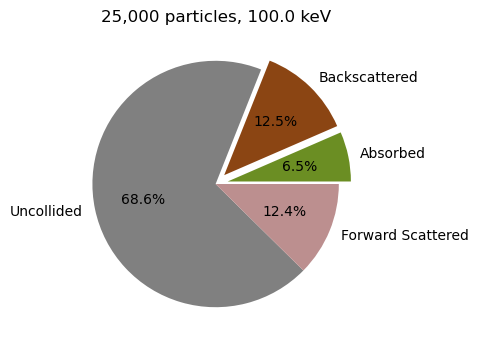

In [62]:
# parameters for generator
multiplier = 7**5
modulus = 2**31 - 1
initial_seed = int(modulus / 2)
MCG = MultiplicativeCongruentialGenerator(initial_seed, multiplier, modulus)

def compute_stdv(N: int, N_1: int, N_expected: float):
    return (N_1/(N_1 - N_expected)**2 + (N - N_1)/(N_expected**2) / (N - 1))**0.5

if __name__ == '__main__':
    N_histories = 25000
    
    N_backscattered = 0
    N_absorbed = 0
    N_uncollided = 0
    N_scattered = 0
    max_N_collisions = 0
    depth = 2.0 # cm
    
    initialX = 0.0 # cm
    initialY = 0.0 # cm
    initialZ = 0.0 # cm
    initialE = 100.0 # keV
    initialMu =  0.0
    initialPhi = 0.0 # radians
    # scatter cosines in stationary coordinate system
    initialOmegaX = 1.0
    initialOmegaY = 0.0
    initialOmegaZ = 0.0
    
    collisions = []
    
    for i in range(N_histories):
        p = Particle(initialX, initialY, initialZ, initialMu, initialPhi, initialOmegaX, initialOmegaY, initialOmegaZ, initialE, MCG)
        while p.x >= 0.0 and p.x <= depth:
            result, N_collisions = p.simulate(water, depth)
            if N_collisions > max_N_collisions:
                max_N_collisions = N_collisions
            if result == -1:
                N_backscattered += 1
                collisions.append(N_collisions)
                break
            elif result == 0:
                N_absorbed += 1
                collisions.append(N_collisions)
                break
            elif result == 1:
                N_uncollided += 1
                collisions.append(N_collisions)
                break
            elif result == 2:
                N_scattered += 1
                collisions.append(N_collisions)
                break
            
    analytical_leakage_flux = np.exp(-depth*water.xs_total[initialE])
    
    print("Number of histories: {}".format(N_histories))
    print("Energy of incident particles: {} keV".format(initialE))
    print("Analytical leakage flux: {}".format(analytical_leakage_flux))
    print("Number of particles backscattered through the x=0 cm plane:\t\t{}".format(N_backscattered))
    print("  Fraction of particles backscattered through the x=0 cm plane:\t\t{} ± {}".format(
        N_backscattered/N_histories,
        compute_stdv(N_histories, N_backscattered, analytical_leakage_flux)/(N_histories**0.5)))
    print("Number of particles absorbed in the medium:\t\t\t\t{}".format(N_absorbed))
    print("  Fraction of particles absorbed in the medium:\t\t\t\t{} ± {}".format(
        N_absorbed/N_histories,
        compute_stdv(N_histories, N_absorbed, analytical_leakage_flux)/(N_histories**0.5)))
    print("Number of particles transmitted through the x=2 cm plane:\t\t{}".format((N_uncollided + N_scattered)))
    print("  Fraction of particles transmitted through the x=2 cm plane:\t\t{} ± {}".format(
        (N_uncollided + N_scattered)/N_histories,
        compute_stdv(N_histories, N_uncollided + N_scattered, analytical_leakage_flux)/(N_histories**0.5))
          + "\n\tNumber uncollided and transmitted:\t\t\t\t{}".format(N_uncollided)
          + "\n\t  Fraction uncollided and transmitted:\t\t\t\t{} ± {}".format(
              N_uncollided/N_histories,
              compute_stdv(N_histories, N_uncollided, analytical_leakage_flux)/(N_histories**0.5))
          + "\n\tNumber scattered and transmitted:\t\t\t\t{}".format(N_scattered)
          + "\n\t  Fraction scattered and transmitted:\t\t\t\t{} ± {}".format(
              N_scattered/N_histories,
              compute_stdv(N_histories, N_scattered, analytical_leakage_flux)/(N_histories**0.5)))
    print("Largest number of collisions in one history:\t\t\t\t{}".format(max_N_collisions))
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.pie(
        [N_absorbed, N_backscattered, N_uncollided, N_scattered],
        labels=["Absorbed", "Backscattered", "Uncollided", "Forward Scattered"],
        colors=['olivedrab', 'saddlebrown', 'gray', 'rosybrown'],
        explode=(0.1, 0.1, 0, 0),
        autopct='%1.1f%%'
    )
    ax.set_title("{:,} particles, {} keV".format(N_histories, initialE))
    plt.show()

Number of histories: 25000
Energy of incident particles: 50.0 keV
Analytical leakage flux: 0.6602742499785037
Number of particles backscattered through the x=0 cm plane:		3515
  Fraction of particles backscattered through the x=0 cm plane:		0.1406 ± 0.00888062114136017
Number of particles absorbed in the medium:				1693
  Fraction of particles absorbed in the medium:				0.06772 ± 0.009250123265250975
Number of particles transmitted through the x=2 cm plane:		19792
  Fraction of particles transmitted through the x=2 cm plane:		0.79168 ± 0.004372227631534235
	Number uncollided and transmitted:				16453
	  Fraction uncollided and transmitted:				0.65812 ± 0.005601031289873116
	Number scattered and transmitted:				3339
	  Fraction scattered and transmitted:				0.13356 ± 0.008916949350588005
Largest number of collisions in one history:				43


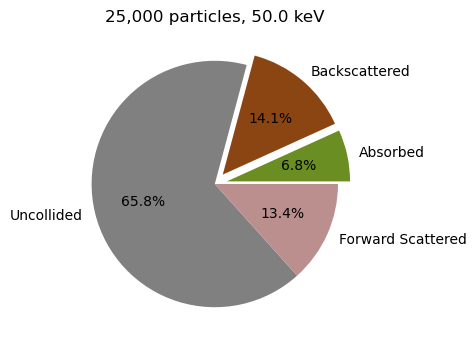

In [63]:
if __name__ == '__main__':
    N_histories = 25000
    
    N_backscattered = 0
    N_absorbed = 0
    N_uncollided = 0
    N_scattered = 0
    max_N_collisions = 0
    depth = 2.0 # cm
    
    initialX = 0.0 # cm
    initialY = 0.0 # cm
    initialZ = 0.0 # cm
    initialE = 50.0 # keV
    initialMu =  0.0
    initialPhi = 0.0 # radians
    # scatter cosines in stationary coordinate system
    initialOmegaX = 1.0
    initialOmegaY = 0.0
    initialOmegaZ = 0.0
    
    collisions = []
    
    for i in range(N_histories):
        p = Particle(initialX, initialY, initialZ, initialMu, initialPhi, initialOmegaX, initialOmegaY, initialOmegaZ, initialE, MCG)
        while p.x >= 0.0 and p.x <= depth:
            result, N_collisions = p.simulate(water, depth)
            if N_collisions > max_N_collisions:
                max_N_collisions = N_collisions
            if result == -1:
                N_backscattered += 1
                collisions.append(N_collisions)
                break
            elif result == 0:
                N_absorbed += 1
                collisions.append(N_collisions)
                break
            elif result == 1:
                N_uncollided += 1
                collisions.append(N_collisions)
                break
            elif result == 2:
                N_scattered += 1
                collisions.append(N_collisions)
                break
            
    analytical_leakage_flux = np.exp(-depth*water.xs_total[initialE])
    
    print("Number of histories: {}".format(N_histories))
    print("Energy of incident particles: {} keV".format(initialE))
    print("Analytical leakage flux: {}".format(analytical_leakage_flux))
    print("Number of particles backscattered through the x=0 cm plane:\t\t{}".format(N_backscattered))
    print("  Fraction of particles backscattered through the x=0 cm plane:\t\t{} ± {}".format(
        N_backscattered/N_histories,
        compute_stdv(N_histories, N_backscattered, analytical_leakage_flux)/(N_histories**0.5)))
    print("Number of particles absorbed in the medium:\t\t\t\t{}".format(N_absorbed))
    print("  Fraction of particles absorbed in the medium:\t\t\t\t{} ± {}".format(
        N_absorbed/N_histories,
        compute_stdv(N_histories, N_absorbed, analytical_leakage_flux)/(N_histories**0.5)))
    print("Number of particles transmitted through the x=2 cm plane:\t\t{}".format((N_uncollided + N_scattered)))
    print("  Fraction of particles transmitted through the x=2 cm plane:\t\t{} ± {}".format(
        (N_uncollided + N_scattered)/N_histories,
        compute_stdv(N_histories, N_uncollided + N_scattered, analytical_leakage_flux)/(N_histories**0.5))
          + "\n\tNumber uncollided and transmitted:\t\t\t\t{}".format(N_uncollided)
          + "\n\t  Fraction uncollided and transmitted:\t\t\t\t{} ± {}".format(
              N_uncollided/N_histories,
              compute_stdv(N_histories, N_uncollided, analytical_leakage_flux)/(N_histories**0.5))
          + "\n\tNumber scattered and transmitted:\t\t\t\t{}".format(N_scattered)
          + "\n\t  Fraction scattered and transmitted:\t\t\t\t{} ± {}".format(
              N_scattered/N_histories,
              compute_stdv(N_histories, N_scattered, analytical_leakage_flux)/(N_histories**0.5)))
    print("Largest number of collisions in one history:\t\t\t\t{}".format(max_N_collisions))
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.pie(
        [N_absorbed, N_backscattered, N_uncollided, N_scattered],
        labels=["Absorbed", "Backscattered", "Uncollided", "Forward Scattered"],
        colors=['olivedrab', 'saddlebrown', 'gray', 'rosybrown'],
        explode=(0.1, 0.1, 0, 0),
        autopct='%1.1f%%'
    )
    ax.set_title("{:,} particles, {} keV".format(N_histories, initialE))
    plt.show()